# result debug

현재 notebook에서 결과 확인용 파일(live test, csv)가 문제 없이 만들어 졌는지 확인

In [1]:
# package load 
import os
import json
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import lightning.pytorch as pl
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.offline as pyo


from conv import *
from PIL import Image
from pathlib import Path
from natsort import natsorted
from tqdm import tqdm_notebook
from matplotlib import gridspec
from collections import defaultdict
from sklearn.metrics import mean_squared_error , confusion_matrix
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from IPython.core.display import HTML
from plotly.subplots import make_subplots

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric


warnings.filterwarnings("ignore")  # avoid printing out absolute paths

/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
class CustomLoss(MultiHorizonMetric):
    """
    Quantile loss, i.e. a quantile of ``q=0.5`` will give half of the mean absolute error as it is calculated as

    Defined as ``max(q * (y-y_pred), (1-q) * (y_pred-y))``
    """

    def __init__(
        self,
        threshold: float = 0.5,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        **kwargs,
    ):
        """
        Quantile loss

        Args:
            quantiles: quantiles for metric
        """
        self.threshold = threshold
        super().__init__(quantiles=quantiles, **kwargs)

    def loss(self, y_pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # calculate quantile loss
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - y_pred[..., i]
            losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(-1) * (self.calculate_f1_loss(target , - y_pred[..., i])))
        losses = 2 * torch.cat(losses, dim=2)

        return losses
    
    def calculate_f1_loss(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        y_true_binary = (y_true > self.threshold).float()
        #y_pred = self.to_prediction(y_pred)
        y_pred_binary = (y_pred > self.threshold).float()

        tp = torch.sum(y_true_binary * y_pred_binary, dim=0)
        fp = torch.sum((1 - y_true_binary) * y_pred_binary, dim=0)
        fn = torch.sum(y_true_binary * (1 - y_pred_binary), dim=0)

        epsilon = 1e-7  # to prevent division by zero
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        return 1 - f1.mean()  # return 1 minus mean f1 score to make it a loss (lower is better)


    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: point prediction
        """
        if y_pred.ndim == 3:
            idx = self.quantiles.index(0.5)
            y_pred = y_pred[..., idx]
        return y_pred

    def to_quantiles(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a quantile prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: prediction quantiles
        """
        return y_pred



In [3]:
transform_type = 'ControlGroup'

# transform_type = lossGroup 으로 해서 코드 실행


quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
alpha_start = 0.7

filter5 = np.array([2, 1, 0]) / 3
filter = np.exp(-np.arange(len(filter5)))

def triangle_conv(time_series):
    global filter
    size = len(filter)
    shift = size // 2
    conv_result = np.convolve(time_series, filter, mode='same')
    conv_result = np.roll(conv_result, shift)
    return conv_result

def inv_conv(time_series):
    return time_series


transformation_dict = {
    'forward': triangle_conv,
    'reverse': inv_conv, 
}


In [4]:
import os
import json
from tqdm.notebook import tqdm_notebook

def get_params(transform_type):
    for params in tqdm_notebook(os.listdir(f'./{transform_type}'), desc='params'):
        params_path = os.path.join(f'./{transform_type}', params)
        json_path = os.path.join(params_path, 'result.json')
        with open(json_path, 'r') as f:
            data = json.load(f)
        key = list(data.keys())[0]
        lr = float(key)
        model_ckpt = data[key]
        return lr, params, model_ckpt

# Call the function with the desired 'transform_type'
transform_type = 'ControlGroup71'
lr, params, model_ckpt = get_params(transform_type)
lr, params, model_ckpt

params:   0%|          | 0/5 [00:00<?, ?it/s]

(0.001,
 '0.001',
 'lightning_logs/ControlGroup71/lightning_logs/version_3/checkpoints/epoch=9-step=22170.ckpt')

In [16]:
import os
import json
from tqdm.notebook import tqdm_notebook

def get_params(transform_type):
    params_list = []
    params_path = os.path.join(f'./{transform_type}', params)
    json_path = os.path.join(params_path, 'result.json')
    with open(json_path, 'r') as f:
        data = json.load(f)
    key = list(data.keys())[0]
    lr = float(key)
    model_ckpt = data[key]
    return lr,  params, model_ckpt

# Call the function with the desired 'transform_type'
transform_type = 'ControlGroup'
dir_list = [dir_name for dir_name in os.listdir(f'./{transform_type}') if dir_name != ".ipynb_checkpoints"]

for params in tqdm_notebook(dir_list, desc='params'):
    lr,  params, model_ckpt = get_params(transform_type)
    print(lr,  params, model_ckpt)


params:   0%|          | 0/7 [00:00<?, ?it/s]

0.001 0.001 lightning_logs/ControlGroup/lightning_logs/version_2/checkpoints/epoch=9-step=22170.ckpt
1e-05 1e-05 lightning_logs/ControlGroup/lightning_logs/version_4/checkpoints/epoch=9-step=22170.ckpt
0.1 0.1 
0.01 0.01 lightning_logs/ControlGroup/lightning_logs/version_1/checkpoints/epoch=9-step=22170.ckpt
1e-07 1e-07 lightning_logs/ControlGroup/lightning_logs/version_6/checkpoints/epoch=9-step=22170.ckpt
1e-06 1e-06 lightning_logs/ControlGroup/lightning_logs/version_5/checkpoints/epoch=9-step=22170.ckpt
0.0001 0.0001 lightning_logs/ControlGroup/lightning_logs/version_3/checkpoints/epoch=9-step=22170.ckpt


In [6]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer

def create_tft_model(model_cpkt):
    max_prediction_length = 24
    max_encoder_length = 24 * 7
    lambda_param = float(params)
    data = pd.read_csv('../../DataProcessing/train_data/Long Beach_5_split.csv')
    training_cutoff = data["time_idx"].max() - max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="Accient",
        group_ids=["GeoHash"],
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=[],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=data.columns[4: -2].tolist(),
        target_normalizer=GroupNormalizer(groups=["GeoHash"], 
                                          transformation=transformation_dict),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    batch_size = 256  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

    load_tft = TemporalFusionTransformer.load_from_checkpoint(model_cpkt)

    return train_dataloader,training, load_tft

train_dataloader, training, load_tft = create_tft_model(model_ckpt)


In [7]:
def get_month_prediction(training , model):
    predictions_list = []
    real_list = []
    atten_list = []
    encoder_target_list = []
    decoder_target_list = []
    steps_dict = defaultdict(list)
    
    val_datas = natsorted(os.listdir('../../DataProcessing/train_data/Long Beach_5_val'), reverse=True)
    for val_idx , val_data_list in enumerate(tqdm_notebook(val_datas , leave=False , desc = 'date processing')):
        val_data_path = os.path.join('../../DataProcessing/train_data/Long Beach_5_val' , val_data_list)
        val_data = pd.read_csv(val_data_path)
        validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)
        val_dataloader = validation.to_dataloader(train=False, batch_size=256, num_workers=0)
        
        
        raw_predictions = model.predict(val_dataloader, mode="raw", return_x=True , trainer_kwargs=dict(accelerator="cpu"))
        model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=7, add_loss_to_title=True)
        
        predictions = load_tft.predict(val_dataloader, mode="raw" , return_x=True , return_index=True ,  trainer_kwargs=dict(accelerator="cpu"))
        raw_predictions ,raw_attention =  predictions[0]['prediction'] , predictions[0]['encoder_attention'].mean(dim=(1,2))                                              
        encoder_target , decoder_target = predictions[1]['encoder_target'] , predictions[1]['decoder_target']
        x,idx_df = predictions[1]['encoder_target'] , predictions[2]
        #return raw_predictions ,  raw_attention , encoder_target , decoder_target , idx_df , x
        
        
        
        predictions_list.append(raw_predictions)
        real_list.append(x)
        atten_list.append(raw_attention)
        decoder_target_list.append(decoder_target)
        encoder_target_list.append(encoder_target)
    
       
    stacked_predictions = np.concatenate(predictions_list, axis=1)
    stacked_real = np.concatenate(real_list, axis=1)
    stacked_atten = np.concatenate(atten_list, axis=1)
    stacked_encoder_target = np.concatenate(encoder_target_list, axis=1)
    stacked_decoder_target = np.concatenate(decoder_target_list, axis=1)
    return stacked_predictions ,  stacked_atten ,stacked_encoder_target , stacked_decoder_target , idx_df
    

In [8]:
def get_month_prediction_scaled(training , model):
    predictions_list = []
    real_list = []
    atten_list = []
    encoder_target_list = []
    decoder_target_list = []
    steps_dict = defaultdict(list)
    
    val_datas = natsorted(os.listdir('../../DataProcessing/train_data/Long Beach_5_val'), reverse=True)
    for val_idx , val_data_list in enumerate(tqdm_notebook(val_datas , leave=False , desc = 'date processing')):
        val_data_path = os.path.join('../../DataProcessing/train_data/Long Beach_5_val' , val_data_list)
        val_data = pd.read_csv(val_data_path)
        validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)
        val_dataloader = validation.to_dataloader(train=False, batch_size=256, num_workers=0)
        
        
        raw_predictions = model.predict(val_dataloader, mode="raw", return_x=True , trainer_kwargs=dict(accelerator="cpu"))
        model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=7, add_loss_to_title=True)
        
        predictions = load_tft.predict(val_dataloader, mode="raw" , return_x=True , return_index=True ,  trainer_kwargs=dict(accelerator="cpu"))
        raw_predictions ,raw_attention =  predictions[0]['prediction'] , predictions[0]['encoder_attention'].mean(dim=(1,2))                                              
        encoder_target , decoder_target = predictions[1]['encoder_target'] , predictions[1]['decoder_target']
        x,idx_df = predictions[1]['encoder_target'] , predictions[2]
        #return raw_predictions ,  raw_attention , encoder_target , decoder_target , idx_df , x
        
        raw_predictions = model.predict(val_dataloader, mode="raw", return_x=True , trainer_kwargs=dict(accelerator="cpu"))
        predictions = raw_predictions.output.prediction
        static_vars = raw_predictions.output.static_variables

        means = static_vars[:, :, 1]
        stds = static_vars[:, :, 2]
        scaled_values = (predictions + means[:, :, np.newaxis]) / stds[:, :, np.newaxis]
        
        
        predictions_list.append(scaled_values)
        real_list.append(x)
        atten_list.append(raw_attention)
        decoder_target_list.append(decoder_target)
        encoder_target_list.append(encoder_target)
    
       
    stacked_predictions = np.concatenate(predictions_list, axis=1)
    stacked_real = np.concatenate(real_list, axis=1)
    stacked_atten = np.concatenate(atten_list, axis=1)
    stacked_encoder_target = np.concatenate(encoder_target_list, axis=1)
    stacked_decoder_target = np.concatenate(decoder_target_list, axis=1)
    return stacked_predictions ,  stacked_atten ,stacked_encoder_target , stacked_decoder_target , idx_df
    

date processing:   0%|          | 0/31 [00:00<?, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-08-23 15:04:55.129174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
I

HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU av

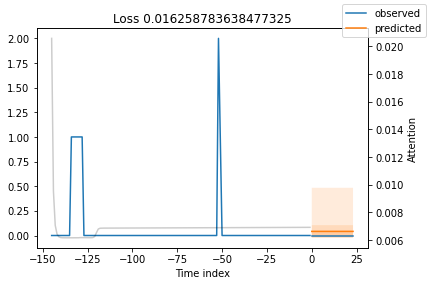

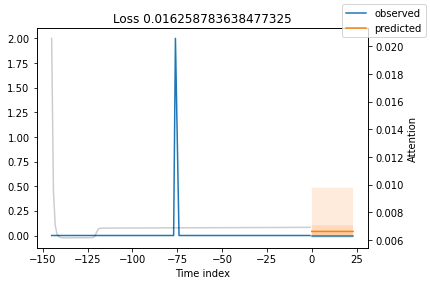

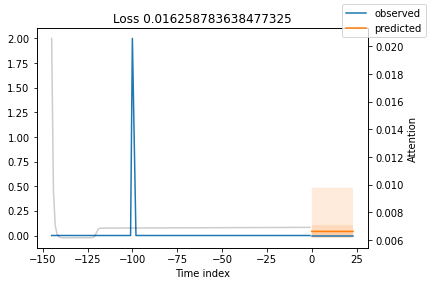

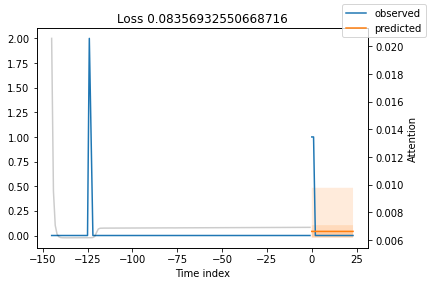

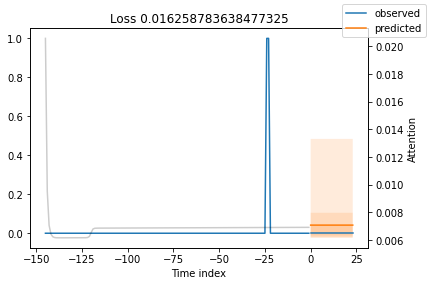

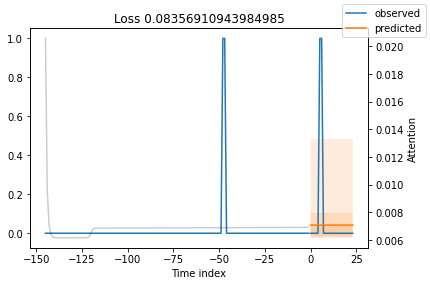

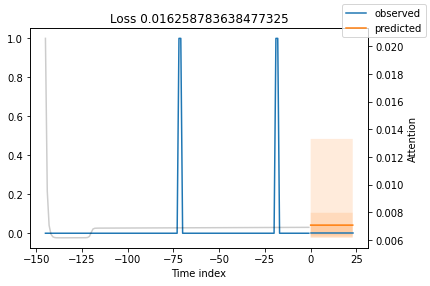

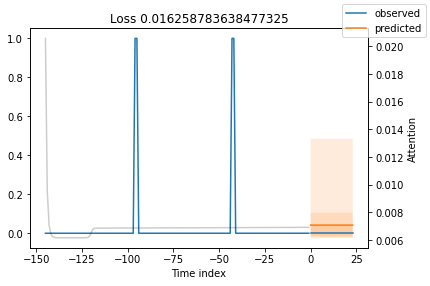

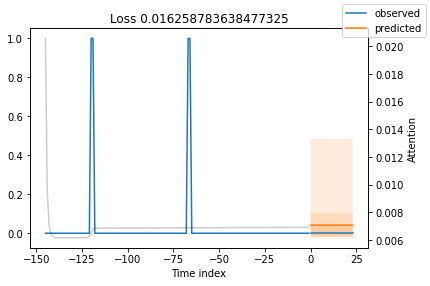

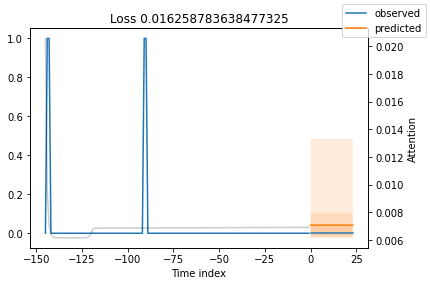

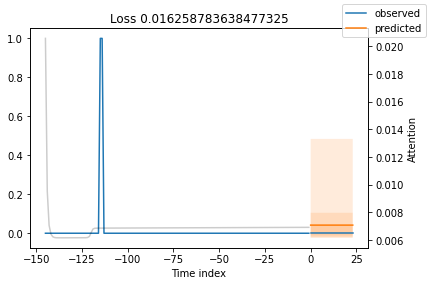

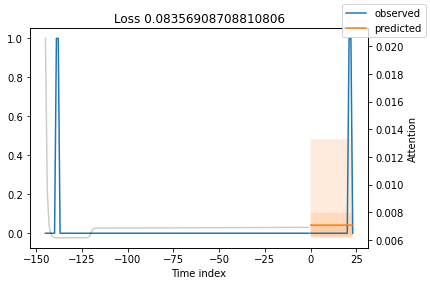

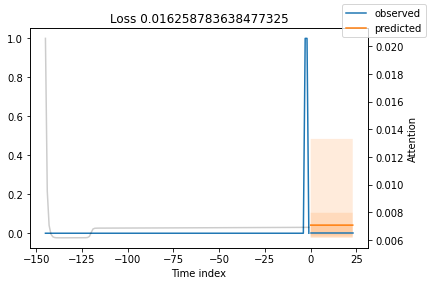

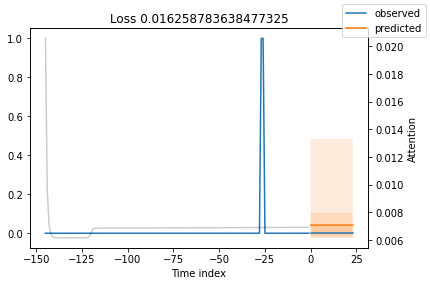

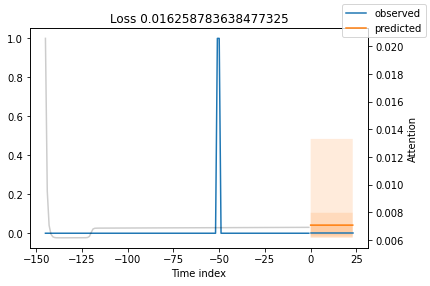

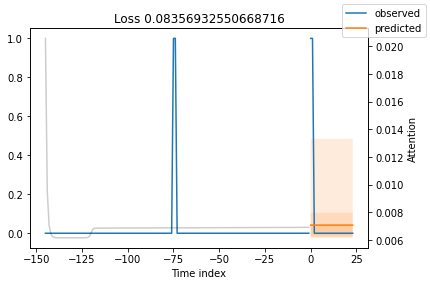

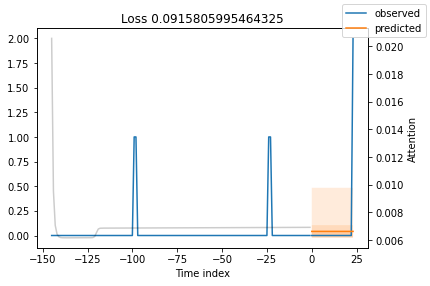

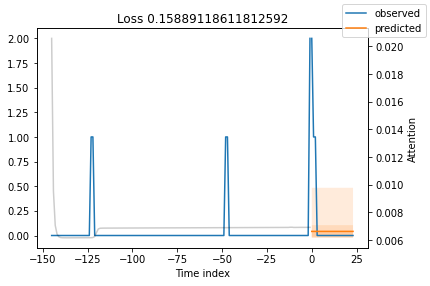

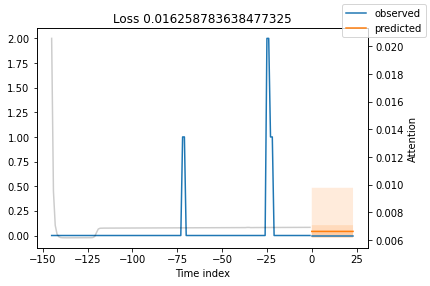

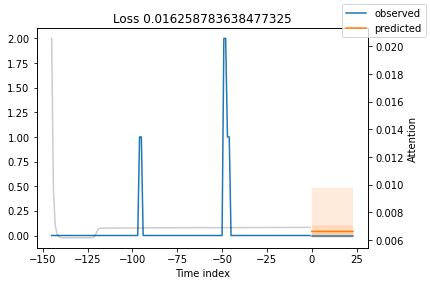

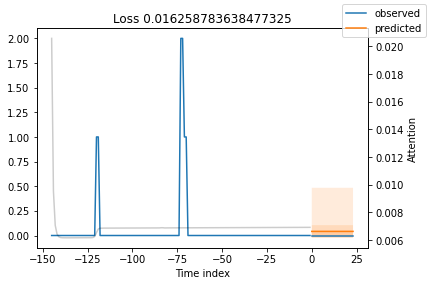

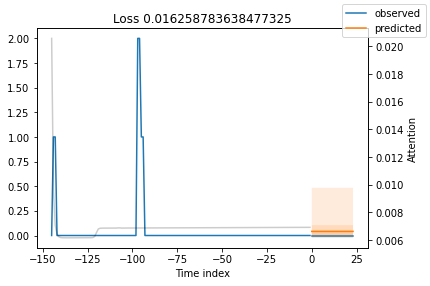

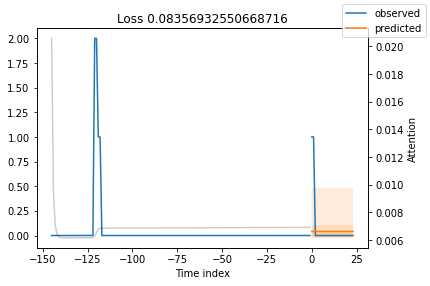

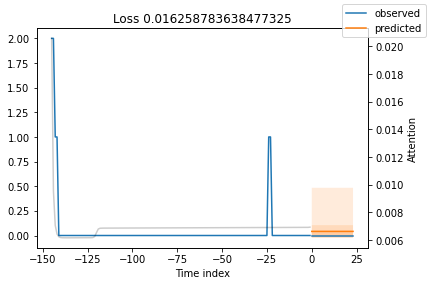

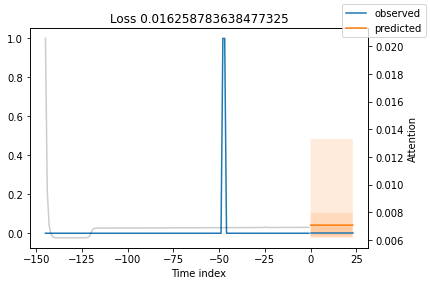

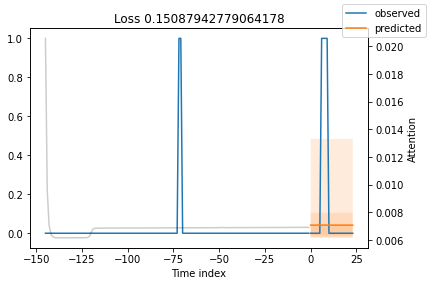

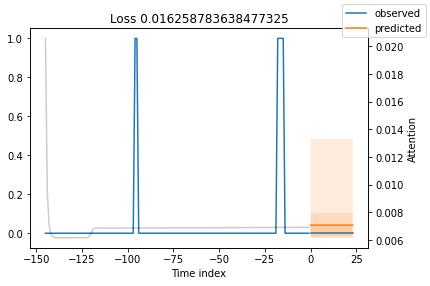

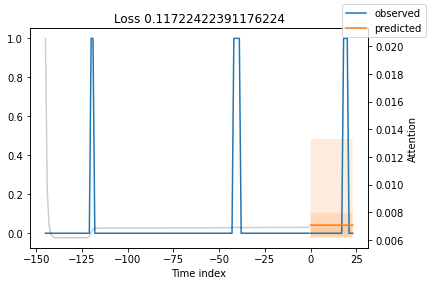

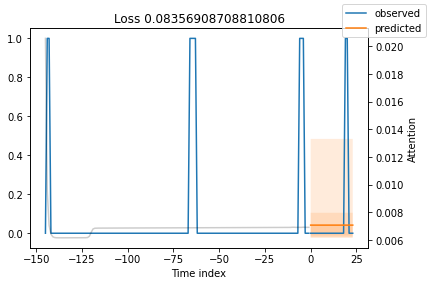

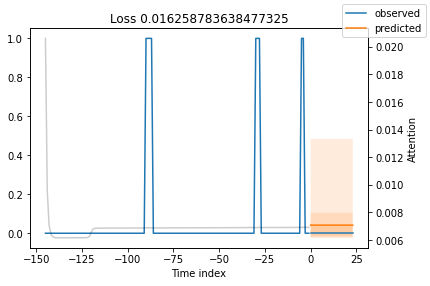

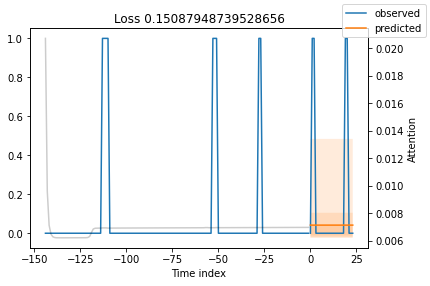

In [17]:
raw_predictions ,  raw_attention , encoder_target , decoder_target , idx_df  = get_month_prediction(training , load_tft)

date processing:   0%|          | 0/31 [00:00<?, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
I

HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU av

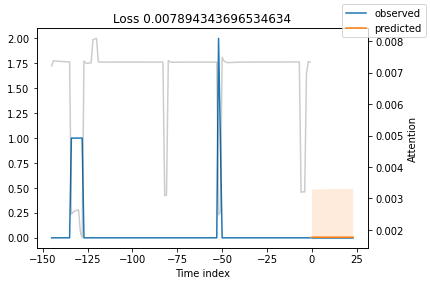

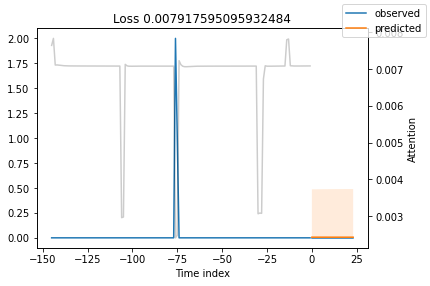

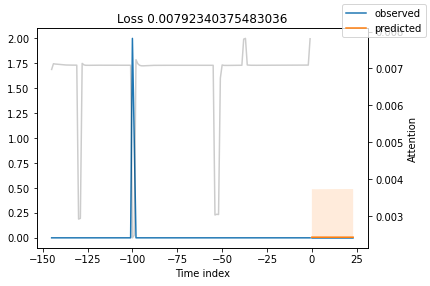

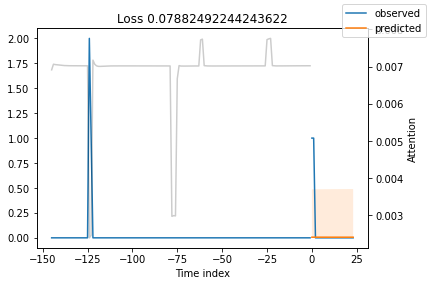

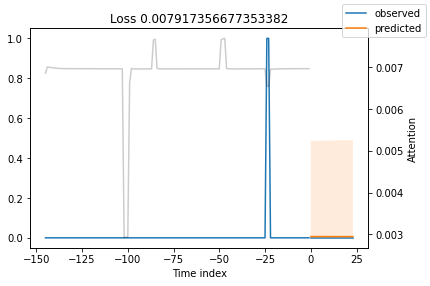

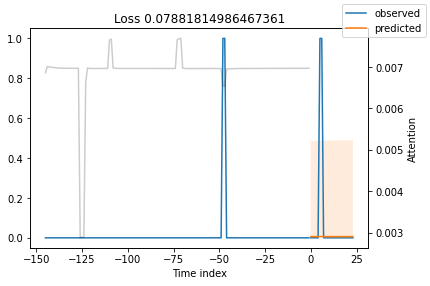

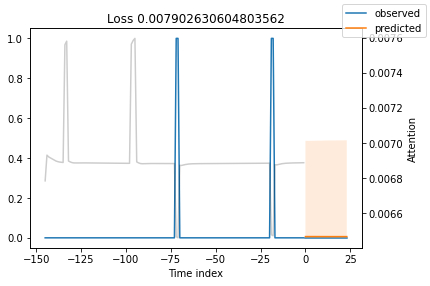

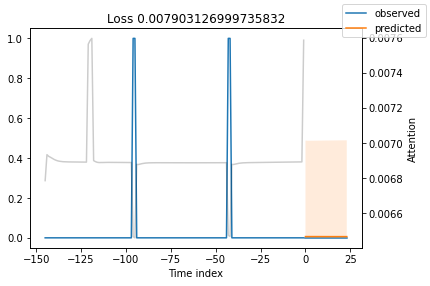

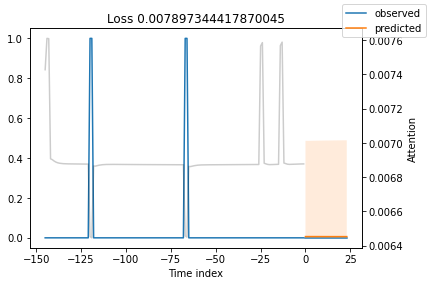

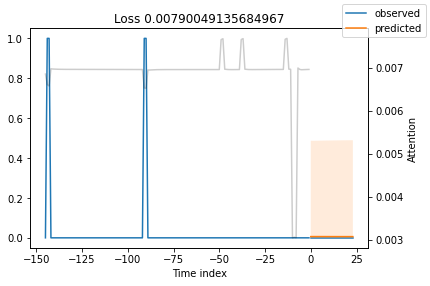

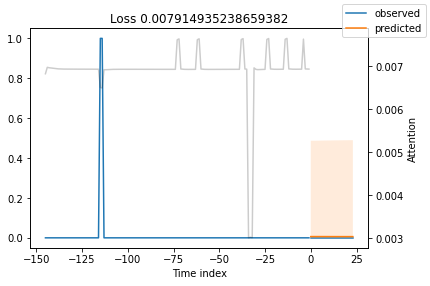

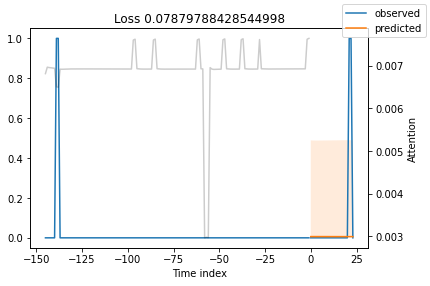

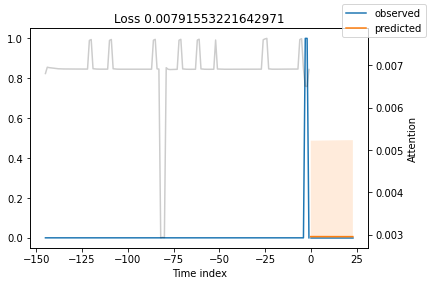

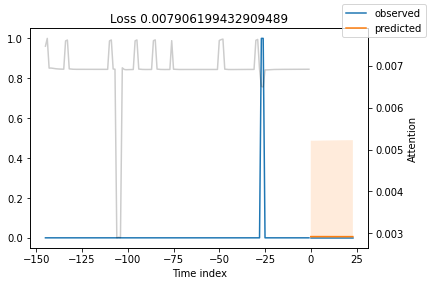

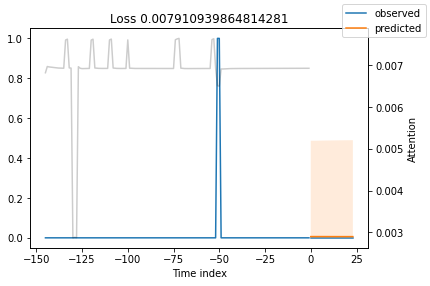

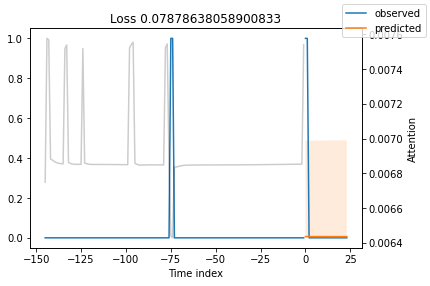

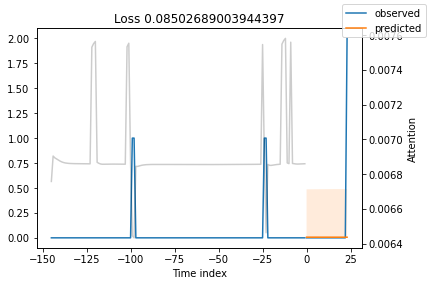

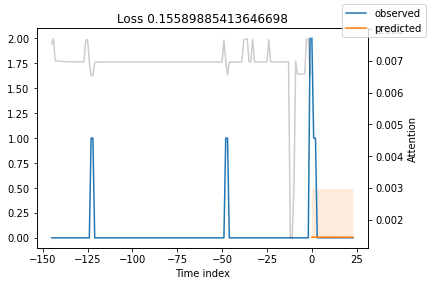

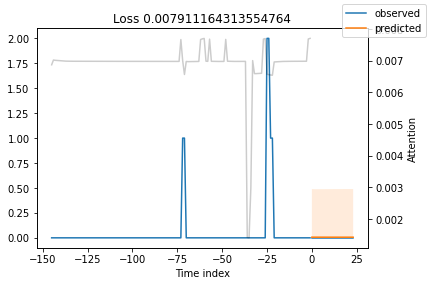

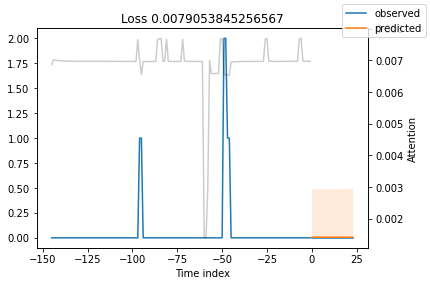

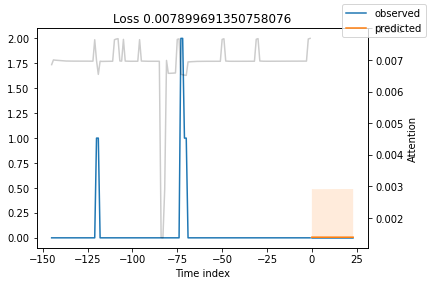

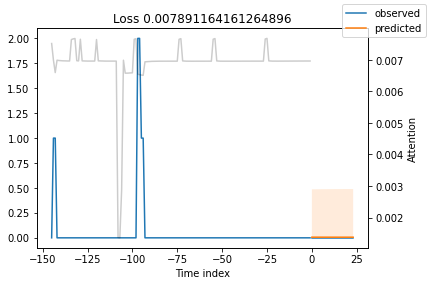

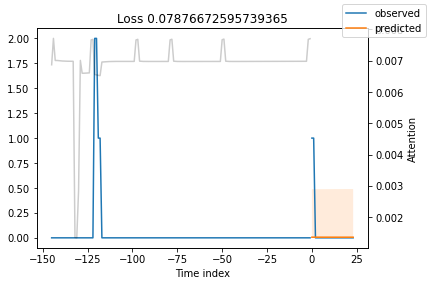

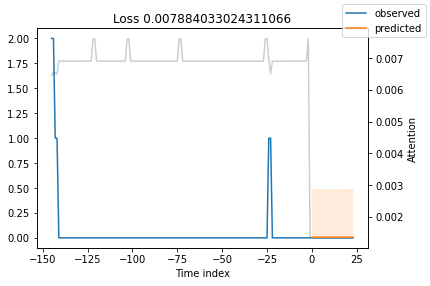

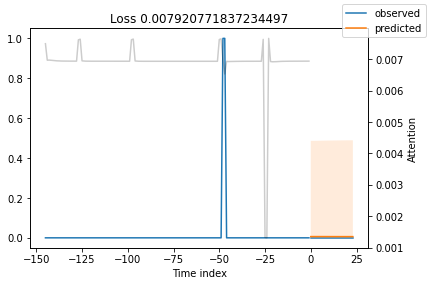

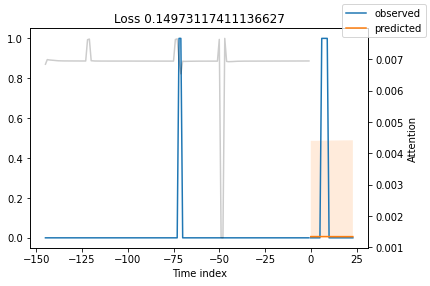

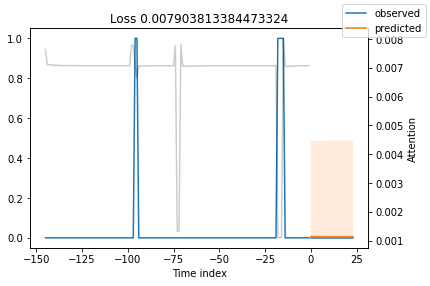

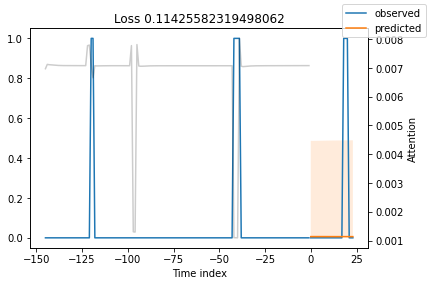

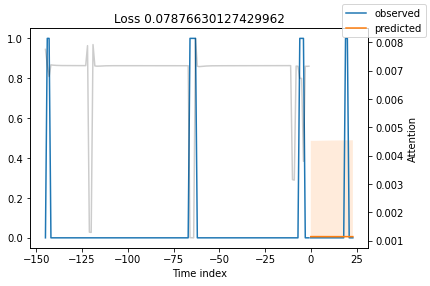

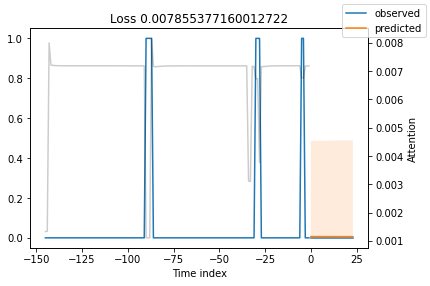

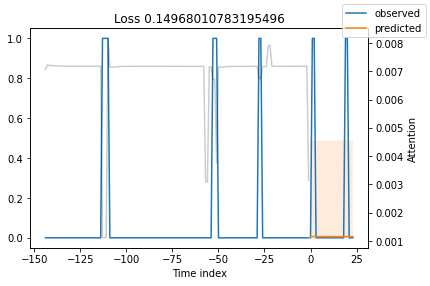

In [35]:
raw_predictions ,  raw_attention , encoder_target , decoder_target , idx_df  = get_month_prediction_scaled(training , load_tft)

date processing:   0%|          | 0/31 [00:00<?, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
I

HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU av

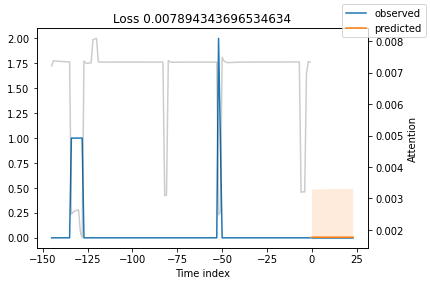

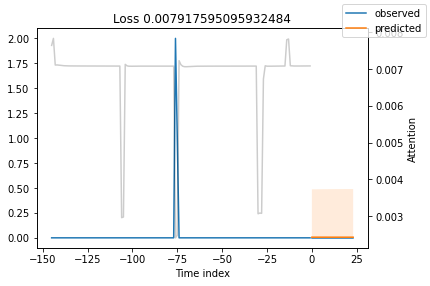

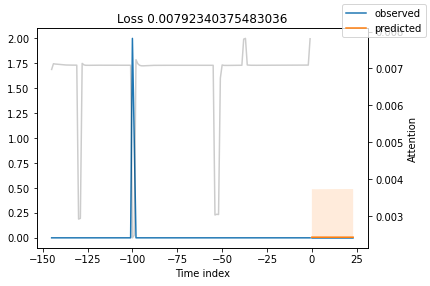

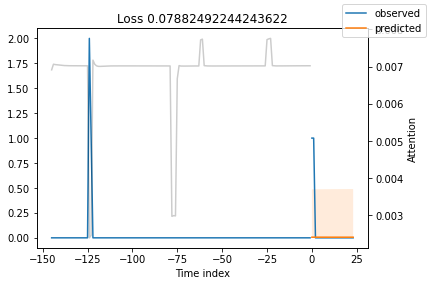

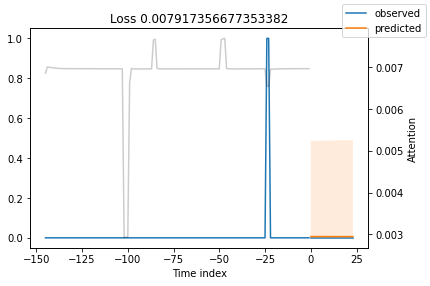

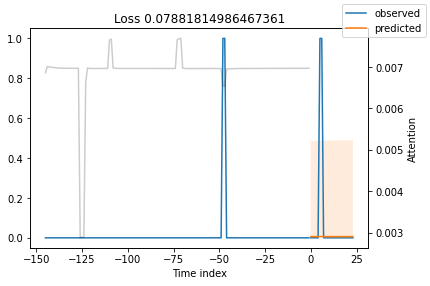

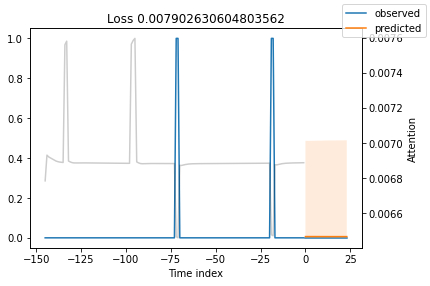

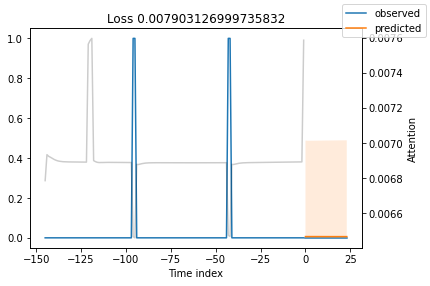

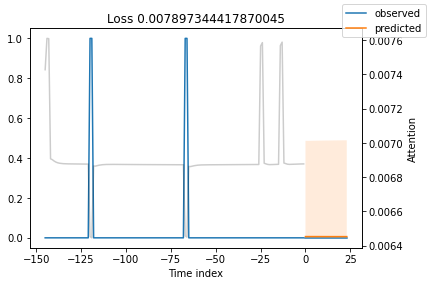

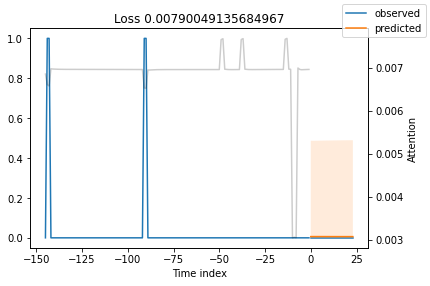

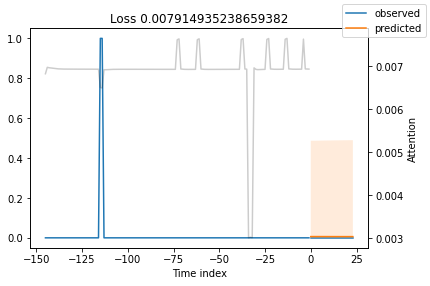

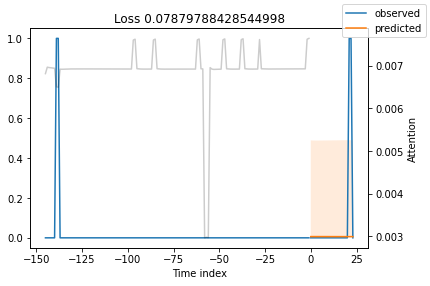

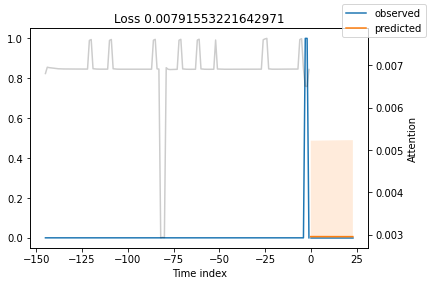

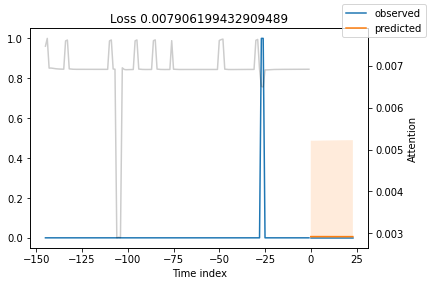

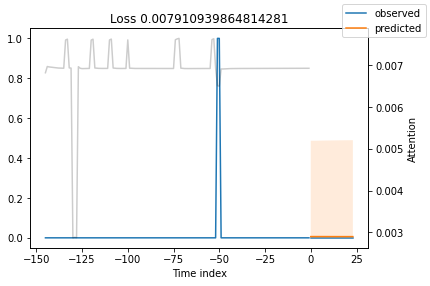

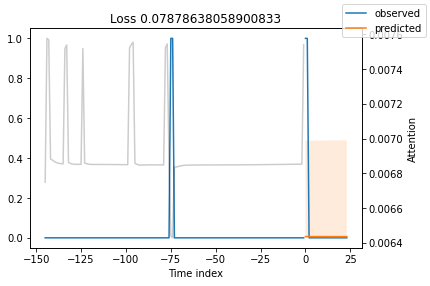

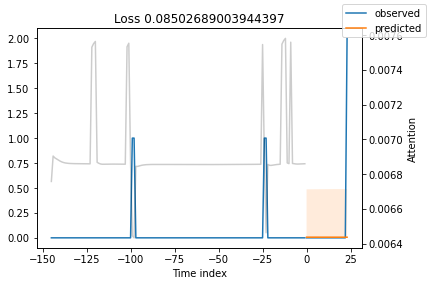

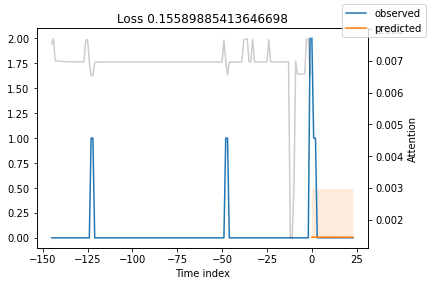

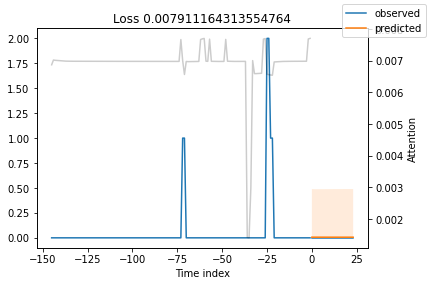

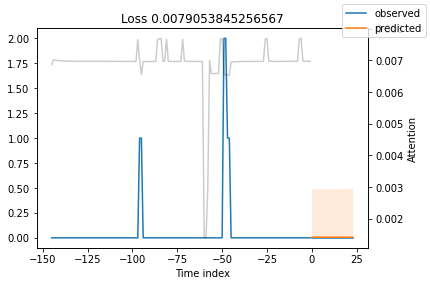

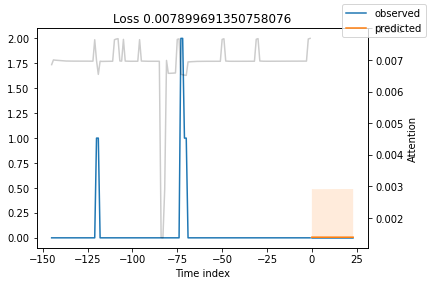

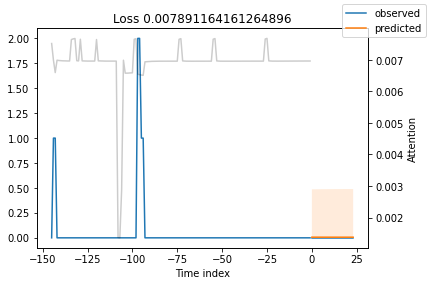

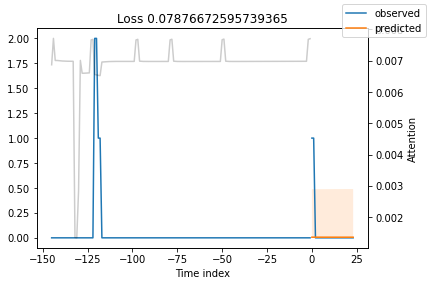

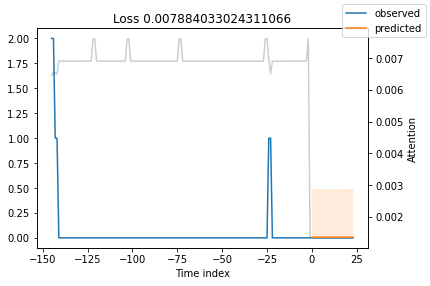

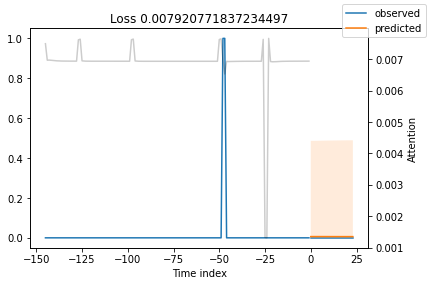

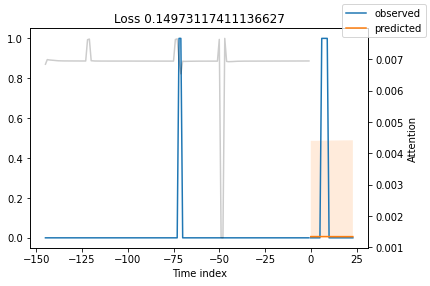

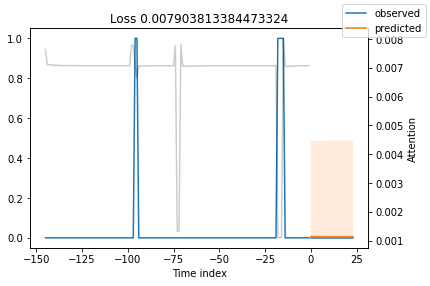

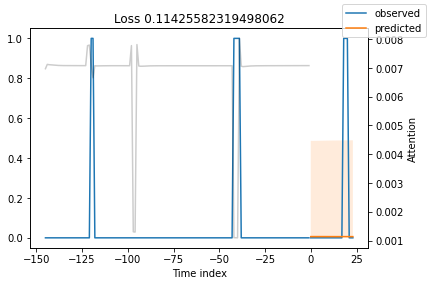

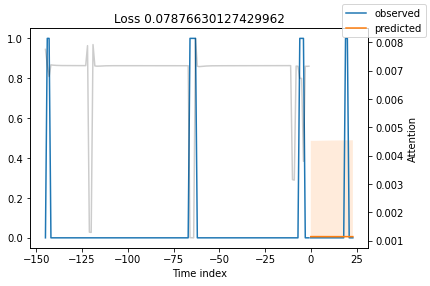

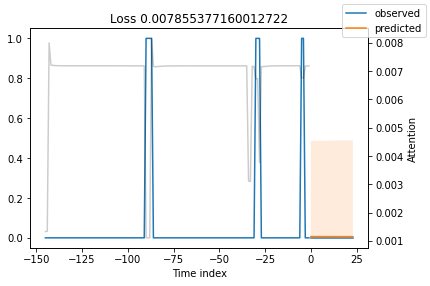

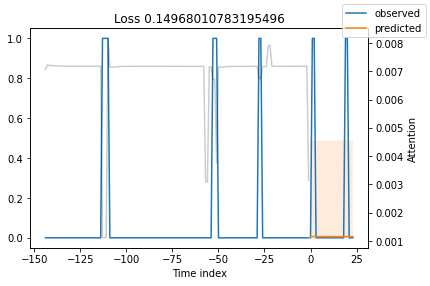

In [20]:
pred_raw ,  atten_raw , encoder_real , decoder_real , idx_df = get_month_prediction(training , load_tft)

In [30]:
quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
alpha_start = 0.7


In [58]:
import os
import plotly.offline as pyo
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_fig_for_geohash(gh, gh_idx, pred, decoder_real, encoder_real, atten, quantiles, alpha_start, transform_type, params, save_dir):
    y_pred = pred[gh_idx]
    y_true = decoder_real[gh_idx]

    fig_plolty = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.1)
    steps = []
    num_steps = pred_raw.shape[1] // 24
    steps_per_group = 10  # Set the number of steps to show per slider group
    
    for i in range(num_steps):
        y_pred = pred[gh_idx, i*24: (i+1)*24]
        y_true = decoder_real[gh_idx, i*24: (i+1)*24]

        for quantile_idx in range(len(quantiles)):
            quantile = quantiles[quantile_idx]
            alpha_color = alpha_start - quantile_idx / len(quantiles) * 0.7
            fillcolor = f'rgba(0, 0, 255, {alpha_color})'

            fig_plolty.add_trace(go.Scatter(
                x=np.arange(0, 24),
                y=y_pred[:, quantile_idx],
                mode='lines',
                name=f'Quantile {quantiles[quantile_idx]}',
                line=dict(color='blue'),
                fill='tozeroy',
                fillcolor=fillcolor,
            ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(0, 24),
            y=decoder_real[gh_idx, i*24: (i+1)*24],
            mode='lines',
            name='Decoder Real',
            line=dict(color='black'),
        ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=encoder_real[gh_idx, i*144: (i+1)*144],
            mode='lines',
            name='Encoder Real',
            line=dict(color='black')
        ), row=1, col=1)

        attention_data = atten[gh_idx, i*144: (i+1)*144]

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=attention_data,
            mode='lines',
            name='Encoder Attention',
            line=dict(color='rgba(128, 128, 128, 0.6)'),
        ), secondary_y=True, row=1, col=1)

    steps = []
    for i in range(num_steps):
        start_idx = i*10
        end_idx = (i + 1)*10
        step = dict(
            method="update",
            args=[
                {"visible": [False] * len(fig_plolty.data)},
                {"title": f"Plot Prediction {gh} day {i}"}
            ]
        )
        step["args"][0]["visible"][start_idx:end_idx] = [True] * (10)
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Steps: "},
        pad={"t": 50},
        steps=steps
    )]

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fig_plolty.update_layout(sliders=sliders)
    fig_plolty.update_yaxes(range=[0, 1])
    fig_plolty.write_html(f'{save_dir}/{gh}.html')
    return fig_plolty

In [59]:
import os
import plotly.offline as pyo
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_fig_for_geohash_q3(gh, gh_idx, pred, decoder_real, encoder_real, atten, quantiles, alpha_start, transform_type, params, save_dir):
    y_pred = pred[gh_idx]
    y_true = decoder_real[gh_idx]

    fig_plolty = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.1)
    steps = []
    num_steps = pred_raw.shape[1] // 24
    steps_per_group = 10  # Set the number of steps to show per slider group
    
    for i in range(num_steps):
        y_pred = pred[gh_idx, i*24: (i+1)*24]
        y_true = decoder_real[gh_idx, i*24: (i+1)*24]

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(0, 24),
            y=y_pred[:, 3],
            mode='lines',
            name=f'Quantile {quantiles[3]}',
            line=dict(color='blue'),
            fill='tozeroy',
        ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(0, 24),
            y=decoder_real[gh_idx, i*24: (i+1)*24],
            mode='lines',
            name='Encoder Real',
            line=dict(color='black'),
        ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=encoder_real[gh_idx, i*144: (i+1)*144],
            mode='lines',
            name='Encoder Real',
            line=dict(color='black')
        ), row=1, col=1)

        attention_data = atten[gh_idx, i*144: (i+1)*144]

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=attention_data,
            mode='lines',
            name='Encoder Attention',
            line=dict(color='rgba(128, 128, 128, 0.6)'),
        ), secondary_y=True, row=1, col=1)

    steps = []
    for i in range(num_steps):
        start_idx = i*4
        end_idx = (i + 1)*4
        step = dict(
            method="update",
            args=[
                {"visible": [False] * len(fig_plolty.data)},
                {"title": f"Plot Prediction {gh} day {i}"}
            ]
        )
        step["args"][0]["visible"][start_idx:end_idx] = [True] * (4)
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Steps: "},
        pad={"t": 50},
        steps=steps
    )]

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fig_plolty.update_layout(sliders=sliders)
    fig_plolty.update_yaxes(range=[0, 1])
    fig_plolty.write_html(f'{save_dir}/{gh}_q3.html')
    return fig_plolty

In [ ]:
save_dir = f'./{transform_type}_result/live_test/{params}'
for gh , gh_idx in list(zip(idx_df['GeoHash'], idx_df.index)):
    print(gh, gh_idx)
    fig = plot_fig_for_geohash(gh  , gh_idx , 
                         pred_raw,  decoder_real , encoder_real, atten_raw, 
                         quantiles, alpha_start, transform_type, params , save_dir)
    fig = plot_fig_for_geohash_q3(gh  , gh_idx , 
                         pred_raw,  decoder_real , encoder_real, atten_raw, 
                         quantiles, alpha_start, transform_type, params , save_dir)
    
    


In [38]:
# metrics 계산 함수버전
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, fbeta_score

def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.mean(np.maximum(quantile * errors, (quantile - 1) * errors))

def calculate_metrics(stacked_real, stacked_predictions, idx_df, quantile=0.5 , threshold=0.05):
    y_true_flattened = stacked_real.flatten()
    y_pred_flattened = stacked_predictions[:, :, 3].flatten()

    y_true_flattened = np.where(y_true_flattened >= 1, 1, y_true_flattened)
    #y_pred_flattened = np.where(y_pred_flattened >= 1, 1, y_pred_flattened)
    y_pred_flattened = np.where(y_pred_flattened >= threshold, 1, 0)
    quantile_loss_value = quantile_loss(y_true_flattened, y_pred_flattened, quantile)
    
    
    mse_value = mean_squared_error(y_true_flattened, y_pred_flattened)
    accuracy_value = accuracy_score(y_true_flattened, y_pred_flattened)
    recall_value = recall_score(y_true_flattened, y_pred_flattened)
    precision_value = precision_score(y_true_flattened, y_pred_flattened)
    f1_score_value = f1_score(y_true_flattened, y_pred_flattened)
    f2_score_value = fbeta_score(y_true_flattened, y_pred_flattened, beta=2)

    results = []

    for dong_idx in range(len(idx_df)):
        dong_name = idx_df.loc[dong_idx, 'GeoHash']
        dong_real = stacked_real[dong_idx]
        dong_real = np.where(dong_real >= 1, 1, dong_real)
        dong_pred = stacked_predictions[dong_idx, :, 3]
        dong_pred = np.where(dong_pred >= threshold, 1, 0)
        
        dong_q_loss = quantile_loss(dong_real, dong_pred, quantile)
        dong_MSE = mean_squared_error(dong_real, dong_pred)
        dong_accuracy = accuracy_score(dong_real, dong_pred)
        dong_recall = recall_score(dong_real, dong_pred)
        dong_precision = precision_score(dong_real, dong_pred)
        dong_f1_score = f1_score(dong_real, dong_pred)
        dong_f2_score = fbeta_score(dong_real, dong_pred, beta=2)
        
        cm = confusion_matrix(dong_real, dong_pred)
        if len(cm) == 1:
            cm = [[744, 0], [0, 0]]

        results.append((cm[0][1] ,cm[0][0] ,cm[1][1] ,cm[1][0] , dong_q_loss, dong_MSE, dong_accuracy, dong_recall, dong_precision, dong_f1_score, dong_f2_score))
    results_df = pd.DataFrame(results, columns=["FP","TN","TP","FN","Quantile Loss", "MSE", "Accuracy", "Recall", "Precision", "F1 Score", "F2 Score"])
    results_df['GeoHash'] = idx_df['GeoHash']

    global_metrics = {"FP" : results_df["FP"].sum(),
                      "TN" : results_df["TN"].sum(),
                      "TP" : results_df["TP"].sum(),
                      "FN" : results_df["FN"].sum(),
                      "Quantile Loss": quantile_loss_value, 
                      "MSE": mse_value, 
                      "Accuracy": accuracy_value, 
                      "Recall": recall_value, 
                      "Precision": precision_value, 
                      "F1 Score": f1_score_value, 
                      "F2 Score": f2_score_value,
                      "GeoHash": "Global"}

    # Append the global metrics to the results dataframe
    results_df = results_df.append(global_metrics, ignore_index=True)
    
    return results_df


### scaling check

scaling 적용 했을 때와 아닌 경우에 대해서 metric_df로 확인

date processing:   0%|          | 0/31 [00:00<?, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
I

HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU av

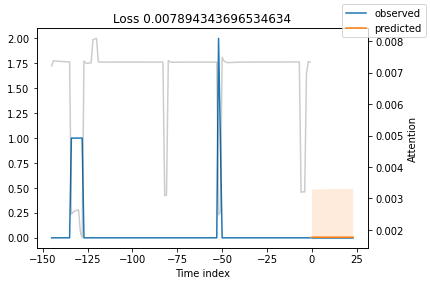

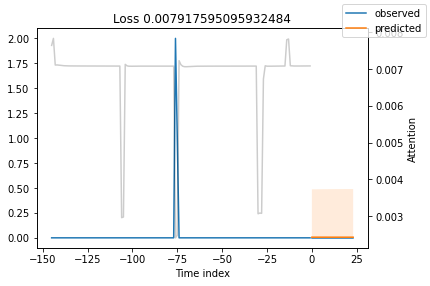

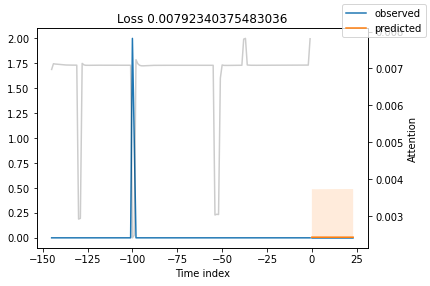

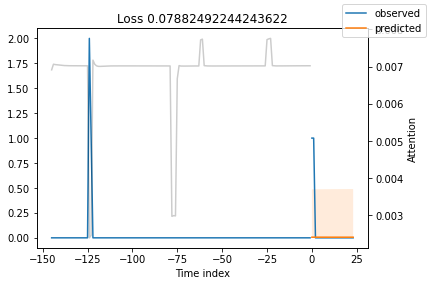

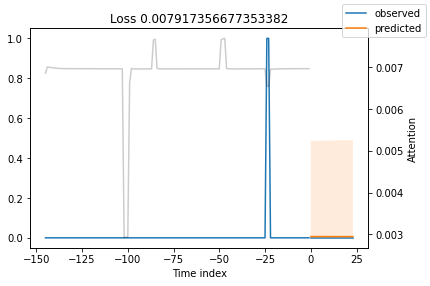

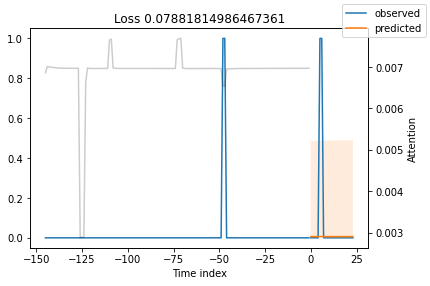

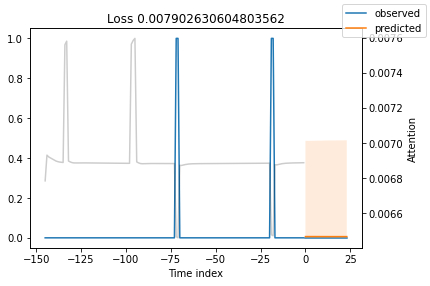

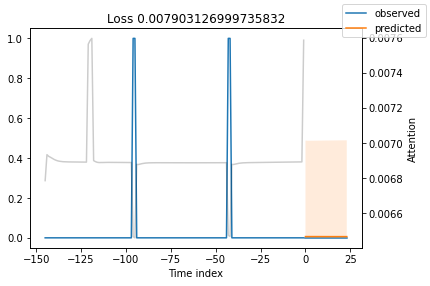

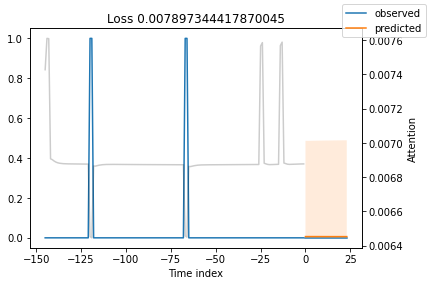

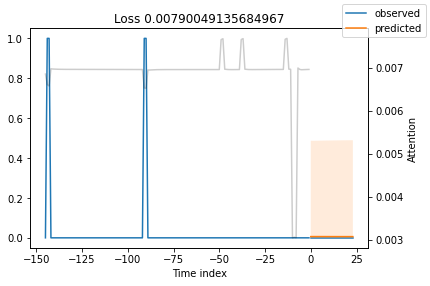

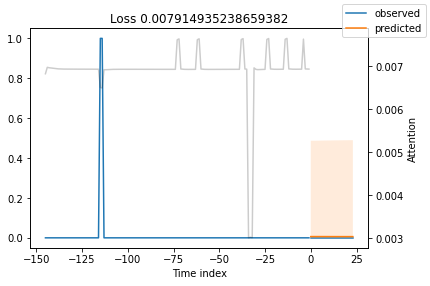

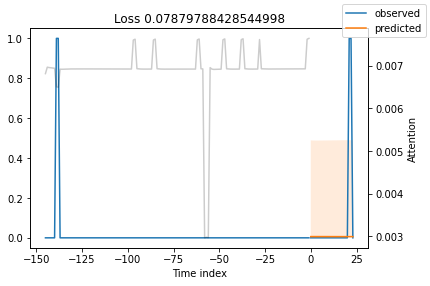

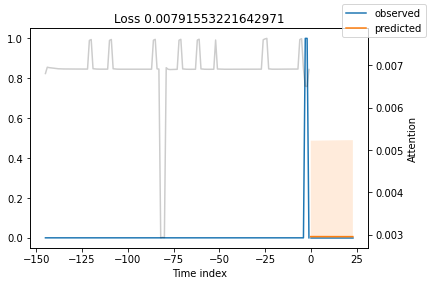

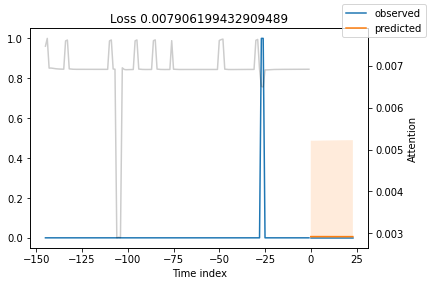

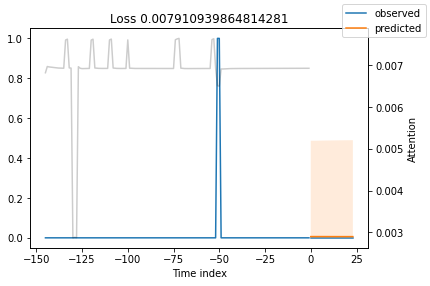

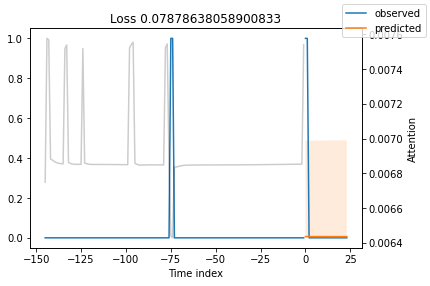

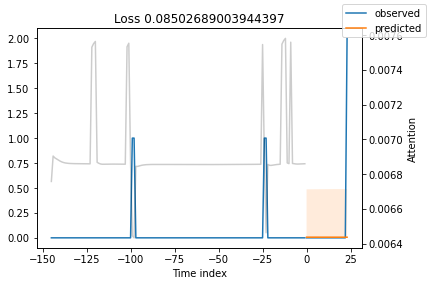

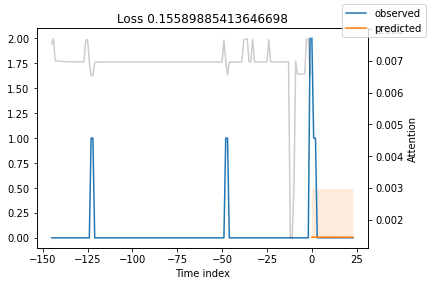

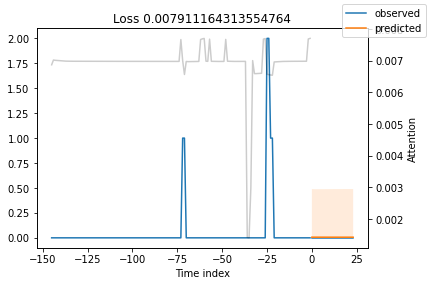

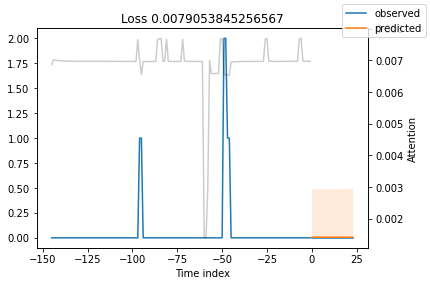

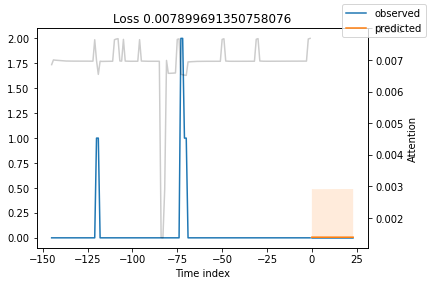

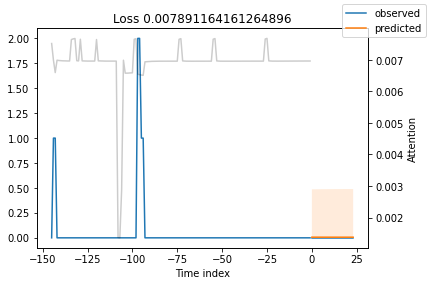

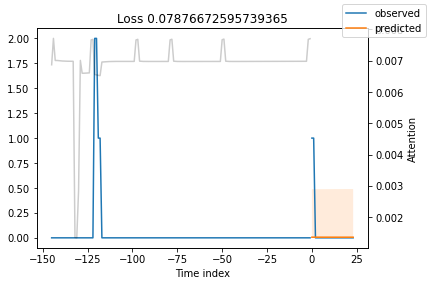

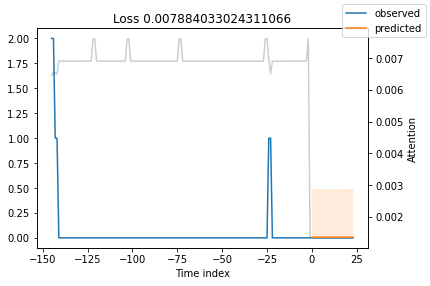

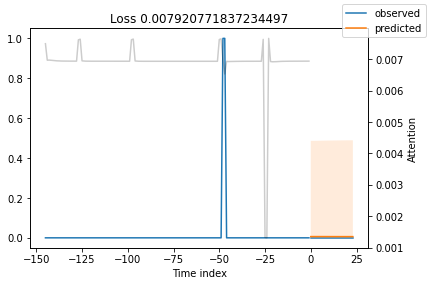

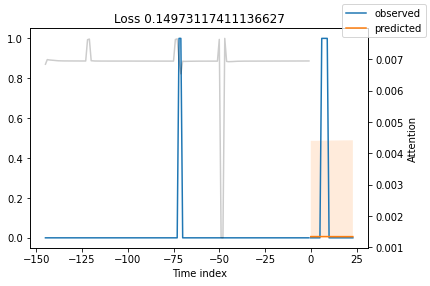

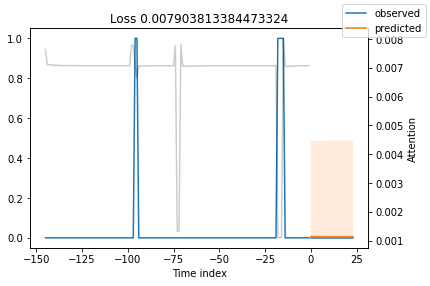

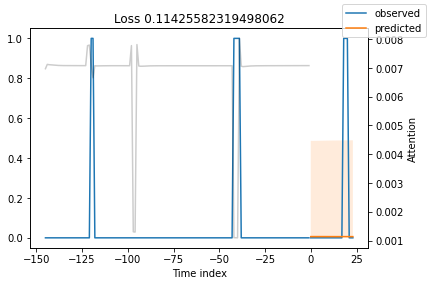

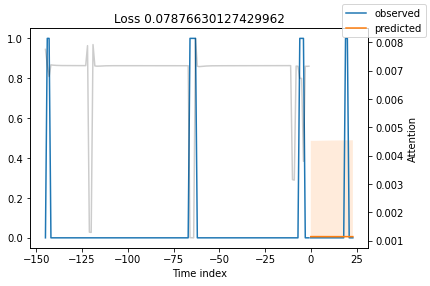

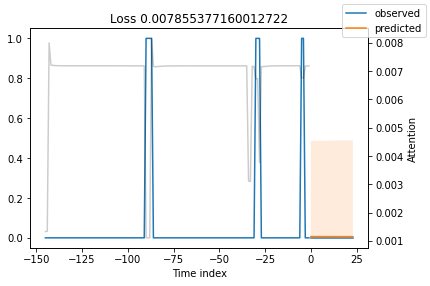

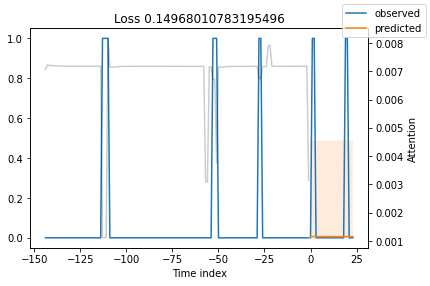

In [217]:
#preds ,  raw_attention , encoder_target , decoder_target , idx_df  = get_month_prediction(training , load_tft)
scaled_preds ,  raw_attention , encoder_target , decoder_target , idx_df  = get_month_prediction_scaled(training , load_tft)

In [124]:
metric_df = calculate_metrics(decoder_real , preds , idx_df)
metric_df

,FP,TN,TP,FN,Quantile Loss,MSE,Accuracy,Recall,Precision,F1 Score,F2 Score,GeoHash
0,0,744,0,0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,9mgzy
1,0,744,0,0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,9mupb
2,0,744,0,0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,9q5bj
3,0,709,0,35,0.023522,0.047043,0.952957,0.0,0.0,0.0,0.0,9q5bm
4,0,730,0,14,0.009409,0.018817,0.981183,0.0,0.0,0.0,0.0,9q5bn
5,0,744,0,0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,9q5bp
6,0,706,0,38,0.025538,0.051075,0.948925,0.0,0.0,0.0,0.0,9q5bq
7,0,717,0,27,0.018145,0.036290,0.963710,0.0,0.0,0.0,0.0,9q5br
8,0,697,0,47,0.031586,0.063172,0.936828,0.0,0.0,0.0,0.0,9q5bw
9,0,730,0,14,0.009409,0.018817,0.981183,0.0,0.0,0.0,0.0,9q5bx


In [125]:
metric_df = calculate_metrics(decoder_real , scaled_preds , idx_df , threshold=0.0)
metric_df

,FP,TN,TP,FN,Quantile Loss,MSE,Accuracy,Recall,Precision,F1 Score,F2 Score,GeoHash
0,744,0,0,0,0.500000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,9mgzy
1,744,0,0,0,0.500000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,9mupb
2,744,0,0,0,0.500000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,9q5bj
3,709,0,35,0,0.476478,0.952957,0.047043,1.0,0.047043,0.089859,0.197964,9q5bm
4,730,0,14,0,0.490591,0.981183,0.018817,1.0,0.018817,0.036939,0.087500,9q5bn
5,744,0,0,0,0.500000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,9q5bp
6,706,0,38,0,0.474462,0.948925,0.051075,1.0,0.051075,0.097187,0.212054,9q5bq
7,717,0,27,0,0.481855,0.963710,0.036290,1.0,0.036290,0.070039,0.158451,9q5br
8,697,0,47,0,0.468414,0.936828,0.063172,1.0,0.063172,0.118837,0.252146,9q5bw
9,730,0,14,0,0.490591,0.981183,0.018817,1.0,0.018817,0.036939,0.087500,9q5bx


In [198]:
def plot_metrics_vs_thresholds(decoder_real, pred_raw, idx_df, thresholds, csv_dir, lr):
    data_to_plot = {col: [] for col in ["FP", "TN", "TP", "FN"]}
    previous_tp = -1
    previous_threshold = None
    fine_tuned_thresholds = None

    for threshold in thresholds:
        metric_df = calculate_metrics(decoder_real, pred_raw, idx_df, threshold=threshold)
        cols_to_select = ["FP", "TN", "TP", "FN"]
        col_indices = [metric_df.columns.get_loc(col) for col in cols_to_select]
        result = metric_df.iloc[15, col_indices]
        current_tp = result["TP"]
        print(current_tp)

        if current_tp > previous_tp and previous_threshold is not None:
            # TP가 더 이상 증가하지 않으면 이 threshold와 이전 threshold 사이에서 미세 조정
            fine_tuned_thresholds = np.linspace(previous_threshold, threshold, 20)
            break

        previous_tp = current_tp
        previous_threshold = threshold

        for col, value in zip(cols_to_select, result.to_list()):
            data_to_plot[col].append(value)

    if fine_tuned_thresholds is None:
                # Plotting using plotly
        fig = go.Figure()
        for metric_name, values in data_to_plot.items():
            fig.add_trace(go.Bar(
                x=thresholds,
                y=values,
                name=metric_name,
                text=values,
                textposition='auto'
            ))

        fig.update_layout(
            barmode='group', 
            title="Metrics for Different Thresholds",
            xaxis_title='Threshold', 
            yaxis_title='Value'
        )

    
    # 미세 조정된 threshold 값들에 대해서도 metric 계산
    else:
        print(fine_tuned_thresholds)
        previous_tp = -1  # 이 부분을 초기화
        optimal_threshold = None

        for threshold in fine_tuned_thresholds:
            metric_df = calculate_metrics(decoder_real, pred_raw, idx_df, threshold=threshold)
            result = metric_df.iloc[15, col_indices]
            current_tp = result["TP"]

            if current_tp > previous_tp and optimal_threshold is None: 
                # 여기서 첫 번째로 TP 값이 증가하지 않는 threshold를 찾습니다.
                optimal_threshold = threshold
            previous_tp = current_tp
            for col, value in zip(cols_to_select, result.to_list()):
                data_to_plot[col].append(value)

        # CSV 파일로 저장
        if optimal_threshold is not None:
            save_path = os.path.join(csv_dir, "optimal_threshold.csv")
            threshold_df = pd.DataFrame({'Optimal_Threshold': [optimal_threshold]})
            threshold_df.to_csv(save_path, index=False)
        # Plotting using plotly
        fig = go.Figure()
        for metric_name, values in data_to_plot.items():
            fig.add_trace(go.Bar(
                x=fine_tuned_thresholds,
                y=values,
                name=metric_name,
                text=values,
                textposition='auto'
            ))

        fig.update_layout(
            barmode='group', 
            title="Metrics for Different Thresholds",
            xaxis_title='Threshold', 
            yaxis_title='Value'
        )
    
    # Specify x-ticks directly
    fig.update_xaxes(tickvals=fine_tuned_thresholds , tickangle=45)
    
    return fig

In [220]:
# Sample usage
thresholds = np.linspace(0.07, 0.004, 10)
csv_dir = "./etc"
lr = 0.001
plot_metrics_vs_thresholds(decoder_real, scaled_preds, idx_df, thresholds, csv_dir, lr)


89
89
89
89
89
116
[0.04066667 0.0402807  0.03989474 0.03950877 0.03912281 0.03873684
 0.03835088 0.03796491 0.03757895 0.03719298 0.03680702 0.03642105
 0.03603509 0.03564912 0.03526316 0.03487719 0.03449123 0.03410526
 0.0337193  0.03333333]


In [221]:
# Sample usage
thresholds = np.linspace(0.01, 0.0001, 10)
csv_dir = "./etc"
lr = 0.001
plot_metrics_vs_thresholds(decoder_real, preds, idx_df, thresholds, csv_dir, lr)


0
0
0
85
[0.0078     0.00774211 0.00768421 0.00762632 0.00756842 0.00751053
 0.00745263 0.00739474 0.00733684 0.00727895 0.00722105 0.00716316
 0.00710526 0.00704737 0.00698947 0.00693158 0.00687368 0.00681579
 0.00675789 0.0067    ]


### plot으로 저장해서 결과값 확인 

In [129]:
save_dir = f'./{transform_type}_result/live_test/{params}_scaled'
for gh , gh_idx in list(zip(idx_df['GeoHash'], idx_df.index)):
    print(gh, gh_idx)
    fig = plot_fig_for_geohash(gh  , gh_idx , 
                         scaled_preds,  decoder_real , encoder_real, atten_raw, 
                         quantiles, alpha_start, transform_type, params , save_dir)
    fig = plot_fig_for_geohash_q3(gh  , gh_idx , 
                         scaled_preds,  decoder_real , encoder_real, atten_raw, 
                         quantiles, alpha_start, transform_type, params , save_dir)
    
    


9mgzy 0
9mupb 1
9q5bj 2
9q5bm 3
9q5bn 4
9q5bp 5
9q5bq 6
9q5br 7
9q5bw 8
9q5bx 9
9q5by 10
9q5bz 11
9qh00 12
9qh02 13
9qh03 14


In [130]:
save_dir = f'./{transform_type}_result/live_test/{params}'
for gh , gh_idx in list(zip(idx_df['GeoHash'], idx_df.index)):
    print(gh, gh_idx)
    fig = plot_fig_for_geohash(gh  , gh_idx , 
                         preds,  decoder_real , encoder_real, atten_raw, 
                         quantiles, alpha_start, transform_type, params , save_dir)
    fig = plot_fig_for_geohash_q3(gh  , gh_idx , 
                         preds,  decoder_real , encoder_real, atten_raw, 
                         quantiles, alpha_start, transform_type, params , save_dir)
    
    


9mgzy 0
9mupb 1
9q5bj 2
9q5bm 3
9q5bn 4
9q5bp 5
9q5bq 6
9q5br 7
9q5bw 8
9q5bx 9
9q5by 10
9q5bz 11
9qh00 12
9qh02 13
9qh03 14


In [6]:
# package load 
import os
import json
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import lightning.pytorch as pl
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.offline as pyo


from conv import *
from PIL import Image
from pathlib import Path
from natsort import natsorted
from tqdm import tqdm_notebook
from matplotlib import gridspec
from collections import defaultdict
from sklearn.metrics import mean_squared_error , confusion_matrix
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from IPython.core.display import HTML
from plotly.subplots import make_subplots

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.metrics.base_metrics import MultiHorizonMetric
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

import os
import json
from tqdm.notebook import tqdm_notebook
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer
import os
import plotly.offline as pyo
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from tqdm import tqdm



class CustomLoss(MultiHorizonMetric):
    """
    Quantile loss, i.e. a quantile of ``q=0.5`` will give half of the mean absolute error as it is calculated as

    Defined as ``max(q * (y-y_pred), (1-q) * (y_pred-y))``
    """

    def __init__(
        self,
        threshold: float = 0.5,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        **kwargs,
    ):
        """
        Quantile loss

        Args:
            quantiles: quantiles for metric
        """
        self.threshold = threshold
        super().__init__(quantiles=quantiles, **kwargs)

    def loss(self, y_pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # calculate quantile loss
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - y_pred[..., i]
            losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(-1) * (self.calculate_f1_loss(target , - y_pred[..., i])))
        losses = 2 * torch.cat(losses, dim=2)

        return losses
    
    def calculate_f1_loss(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        y_true_binary = (y_true > self.threshold).float()
        #y_pred = self.to_prediction(y_pred)
        y_pred_binary = (y_pred > self.threshold).float()

        tp = torch.sum(y_true_binary * y_pred_binary, dim=0)
        fp = torch.sum((1 - y_true_binary) * y_pred_binary, dim=0)
        fn = torch.sum(y_true_binary * (1 - y_pred_binary), dim=0)

        epsilon = 1e-7  # to prevent division by zero
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        return 1 - f1.mean()  # return 1 minus mean f1 score to make it a loss (lower is better)


    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: point prediction
        """
        if y_pred.ndim == 3:
            idx = self.quantiles.index(0.5)
            y_pred = y_pred[..., idx]
        return y_pred

    def to_quantiles(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a quantile prediction.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: prediction quantiles
        """
        return y_pred

def get_params(transform_type):
    for params in tqdm(os.listdir(f'./{transform_type}'), desc='params'):
        params_path = os.path.join(f'./{transform_type}', params)
        json_path = os.path.join(params_path, 'result.json')
        with open(json_path, 'r') as f:
            data = json.load(f)
        key = list(data.keys())[0]
        lr = float(key)
        model_ckpt = data[key]
        return lr, params, model_ckpt

def create_tft_model(model_cpkt):
    max_prediction_length = 24
    max_encoder_length = 24 * 7
    lambda_param = float(params)
    data = pd.read_csv('../../DataProcessing/train_data/Long Beach_5_split.csv')
    training_cutoff = data["time_idx"].max() - max_prediction_length

    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="Accient",
        group_ids=["GeoHash"],
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=[],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=data.columns[4: -2].tolist(),
        target_normalizer=GroupNormalizer(groups=["GeoHash"], 
                                          transformation=transformation_dict),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    batch_size = 256  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

    load_tft = TemporalFusionTransformer.load_from_checkpoint(model_cpkt)

    return train_dataloader,training, load_tft

def get_month_prediction(training , model):
    predictions_list = []
    real_list = []
    atten_list = []
    encoder_target_list = []
    decoder_target_list = []
    steps_dict = defaultdict(list)
    
    val_datas = natsorted(os.listdir('../../DataProcessing/train_data/Long Beach_5_val'), reverse=True)
    for val_idx , val_data_list in enumerate(tqdm_notebook(val_datas , leave=False , desc = 'date processing')):
        val_data_path = os.path.join('../../DataProcessing/train_data/Long Beach_5_val' , val_data_list)
        val_data = pd.read_csv(val_data_path)
        validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)
        val_dataloader = validation.to_dataloader(train=False, batch_size=256, num_workers=0)
        
        
        raw_predictions = model.predict(val_dataloader, mode="raw", return_x=True , trainer_kwargs=dict(accelerator="cpu"))
        model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=7, add_loss_to_title=True)
        
        predictions = load_tft.predict(val_dataloader, mode="raw" , return_x=True , return_index=True ,  trainer_kwargs=dict(accelerator="cpu"))
        raw_predictions ,raw_attention =  predictions[0]['prediction'] , predictions[0]['encoder_attention'].mean(dim=(1,2))                                              
        encoder_target , decoder_target = predictions[1]['encoder_target'] , predictions[1]['decoder_target']
        x,idx_df = predictions[1]['encoder_target'] , predictions[2]
        #return raw_predictions ,  raw_attention , encoder_target , decoder_target , idx_df , x
        
        
        
        predictions_list.append(raw_predictions)
        real_list.append(x)
        atten_list.append(raw_attention)
        decoder_target_list.append(decoder_target)
        encoder_target_list.append(encoder_target)
    
       
    stacked_predictions = np.concatenate(predictions_list, axis=1)
    stacked_real = np.concatenate(real_list, axis=1)
    stacked_atten = np.concatenate(atten_list, axis=1)
    stacked_encoder_target = np.concatenate(encoder_target_list, axis=1)
    stacked_decoder_target = np.concatenate(decoder_target_list, axis=1)
    return stacked_predictions ,  stacked_atten ,stacked_encoder_target , stacked_decoder_target , idx_df
    
def plot_fig_for_geohash(gh, gh_idx, pred, decoder_real, encoder_real, atten, quantiles, alpha_start, transform_type, params, save_dir):
    y_pred = pred[gh_idx]
    y_true = decoder_real[gh_idx]

    fig_plolty = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.1)
    steps = []
    num_steps = pred.shape[1] // 24
    steps_per_group = 10  # Set the number of steps to show per slider group
    
    for i in range(num_steps):
        y_pred = pred[gh_idx, i*24: (i+1)*24]
        y_true = decoder_real[gh_idx, i*24: (i+1)*24]

        for quantile_idx in range(len(quantiles)):
            quantile = quantiles[quantile_idx]
            alpha_color = alpha_start - quantile_idx / len(quantiles) * 0.7
            fillcolor = f'rgba(0, 0, 255, {alpha_color})'

            fig_plolty.add_trace(go.Scatter(
                x=np.arange(0, 24),
                y=y_pred[:, quantile_idx],
                mode='lines',
                name=f'Quantile {quantiles[quantile_idx]}',
                line=dict(color='blue'),
                fill='tozeroy',
                fillcolor=fillcolor,
            ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(0, 24),
            y=decoder_real[gh_idx, i*24: (i+1)*24],
            mode='lines',
            name='Decoder Real',
            line=dict(color='black'),
        ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=encoder_real[gh_idx, i*144: (i+1)*144],
            mode='lines',
            name='Encoder Real',
            line=dict(color='black')
        ), row=1, col=1)

        attention_data = atten[gh_idx, i*144: (i+1)*144]

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=attention_data,
            mode='lines',
            name='Encoder Attention',
            line=dict(color='rgba(128, 128, 128, 0.6)'),
        ), secondary_y=True, row=1, col=1)

    steps = []
    for i in range(num_steps):
        start_idx = i*10
        end_idx = (i + 1)*10
        step = dict(
            method="update",
            args=[
                {"visible": [False] * len(fig_plolty.data)},
                {"title": f"Plot Prediction {gh} day {i}"}
            ]
        )
        step["args"][0]["visible"][start_idx:end_idx] = [True] * (10)
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Steps: "},
        pad={"t": 50},
        steps=steps
    )]

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fig_plolty.update_layout(sliders=sliders)
    fig_plolty.update_yaxes(range=[0, 1])
    fig_plolty.write_html(f'{save_dir}/{gh}.html')
    return fig_plolty

def plot_fig_for_geohash_q3(gh, gh_idx, pred, decoder_real, encoder_real, atten, quantiles, alpha_start, transform_type, params, save_dir):
    y_pred = pred[gh_idx]
    y_true = decoder_real[gh_idx]

    fig_plolty = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]], vertical_spacing=0.1)
    steps = []
    num_steps = pred.shape[1] // 24
    steps_per_group = 10  # Set the number of steps to show per slider group
    
    for i in range(num_steps):
        y_pred = pred[gh_idx, i*24: (i+1)*24]
        y_true = decoder_real[gh_idx, i*24: (i+1)*24]

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(0, 24),
            y=y_pred[:, 3],
            mode='lines',
            name=f'Quantile {quantiles[3]}',
            line=dict(color='blue'),
            fill='tozeroy',
        ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(0, 24),
            y=decoder_real[gh_idx, i*24: (i+1)*24],
            mode='lines',
            name='Encoder Real',
            line=dict(color='black'),
        ), row=1, col=1)

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=encoder_real[gh_idx, i*144: (i+1)*144],
            mode='lines',
            name='Encoder Real',
            line=dict(color='black')
        ), row=1, col=1)

        attention_data = atten[gh_idx, i*144: (i+1)*144]

        fig_plolty.add_trace(go.Scatter(
            x=np.arange(-168 + 24, 24),
            y=attention_data,
            mode='lines',
            name='Encoder Attention',
            line=dict(color='rgba(128, 128, 128, 0.6)'),
        ), secondary_y=True, row=1, col=1)

    steps = []
    for i in range(num_steps):
        start_idx = i*4
        end_idx = (i + 1)*4
        step = dict(
            method="update",
            args=[
                {"visible": [False] * len(fig_plolty.data)},
                {"title": f"Plot Prediction {gh} day {i}"}
            ]
        )
        step["args"][0]["visible"][start_idx:end_idx] = [True] * (4)
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Steps: "},
        pad={"t": 50},
        steps=steps
    )]

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fig_plolty.update_layout(sliders=sliders)
    fig_plolty.update_yaxes(range=[0, 1])
    fig_plolty.write_html(f'{save_dir}/{gh}_q3.html')
    return fig_plolty

def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.mean(np.maximum(quantile * errors, (quantile - 1) * errors))

def calculate_metrics(stacked_real, stacked_predictions, idx_df, quantile=0.5 , threshold=0.05):
    y_true_flattened = stacked_real.flatten()
    y_pred_flattened = stacked_predictions[:, :, 3].flatten()

    y_true_flattened = np.where(y_true_flattened >= 1, 1, y_true_flattened)
    #y_pred_flattened = np.where(y_pred_flattened >= 1, 1, y_pred_flattened)
    y_pred_flattened = np.where(y_pred_flattened >= threshold, 1, 0)
    quantile_loss_value = quantile_loss(y_true_flattened, y_pred_flattened, quantile)
    
    
    mse_value = mean_squared_error(y_true_flattened, y_pred_flattened)
    accuracy_value = accuracy_score(y_true_flattened, y_pred_flattened)
    recall_value = recall_score(y_true_flattened, y_pred_flattened)
    precision_value = precision_score(y_true_flattened, y_pred_flattened)
    f1_score_value = f1_score(y_true_flattened, y_pred_flattened)
    f2_score_value = fbeta_score(y_true_flattened, y_pred_flattened, beta=2)

    results = []

    for dong_idx in range(len(idx_df)):
        dong_name = idx_df.loc[dong_idx, 'GeoHash']
        dong_real = stacked_real[dong_idx]
        dong_real = np.where(dong_real >= 1, 1, dong_real)
        dong_pred = stacked_predictions[dong_idx, :, 3]
        dong_pred = np.where(dong_pred >= threshold, 1, 0)
        
        dong_q_loss = quantile_loss(dong_real, dong_pred, quantile)
        dong_MSE = mean_squared_error(dong_real, dong_pred)
        dong_accuracy = accuracy_score(dong_real, dong_pred)
        dong_recall = recall_score(dong_real, dong_pred)
        dong_precision = precision_score(dong_real, dong_pred)
        dong_f1_score = f1_score(dong_real, dong_pred)
        dong_f2_score = fbeta_score(dong_real, dong_pred, beta=2)
        
        cm = confusion_matrix(dong_real, dong_pred)
        if len(cm) == 1:
            cm = [[744, 0], [0, 0]]

        results.append((cm[0][1] ,cm[0][0] ,cm[1][1] ,cm[1][0] , dong_q_loss, dong_MSE, dong_accuracy, dong_recall, dong_precision, dong_f1_score, dong_f2_score))
    results_df = pd.DataFrame(results, columns=["FP","TN","TP","FN","Quantile Loss", "MSE", "Accuracy", "Recall", "Precision", "F1 Score", "F2 Score"])
    results_df['GeoHash'] = idx_df['GeoHash']

    global_metrics = {"FP" : results_df["FP"].sum(),
                      "TN" : results_df["TN"].sum(),
                      "TP" : results_df["TP"].sum(),
                      "FN" : results_df["FN"].sum(),
                      "Quantile Loss": quantile_loss_value, 
                      "MSE": mse_value, 
                      "Accuracy": accuracy_value, 
                      "Recall": recall_value, 
                      "Precision": precision_value, 
                      "F1 Score": f1_score_value, 
                      "F2 Score": f2_score_value,
                      "GeoHash": "Global"}

    # Append the global metrics to the results dataframe
    results_df = results_df.append(global_metrics, ignore_index=True)
    
    return results_df

In [ ]:
transform_type = 'ControlGroup71'
lr, params, model_ckpt = get_params(transform_type)
train_dataloader, training, load_tft = create_tft_model(model_ckpt)
raw_predictions ,  raw_attention , encoder_target , decoder_target , idx_df  = get_month_prediction(training , load_tft)

quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
alpha_start = 0.7

save_fig_dir = f'./{transform_type}_result/live_test/{params}'
for gh , gh_idx in list(zip(idx_df['GeoHash'], idx_df.index)):
    print(gh, gh_idx)
    fig = plot_fig_for_geohash(gh  , gh_idx , 
                         raw_predictions,  decoder_target , encoder_target, raw_attention, 
                         quantiles, alpha_start, transform_type, params , save_fig_dir)
    fig = plot_fig_for_geohash_q3(gh  , gh_idx , 
                         raw_predictions,  decoder_target , encoder_target, raw_attention, 
                         quantiles, alpha_start, transform_type, params , save_fig_dir)
metric_df = calculate_metrics(decoder_real , preds , idx_df)
save_csv_dir = f'./{transform_type}_result/csv/{params}.csv'
metric_df.to_csv(save_csv_dir)


In [18]:
quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
alpha_start = 0.7

save_fig_dir = f'./{transform_type}_result/live_test/{params}'
for gh , gh_idx in list(zip(idx_df['GeoHash'], idx_df.index)):
    print(gh, gh_idx)
    fig = plot_fig_for_geohash(gh  , gh_idx , 
                         raw_predictions,  decoder_target , encoder_target, raw_attention, 
                         quantiles, alpha_start, transform_type, params , save_fig_dir)
    fig = plot_fig_for_geohash_q3(gh  , gh_idx , 
                         raw_predictions,  decoder_target , encoder_target, raw_attention, 
                         quantiles, alpha_start, transform_type, params , save_fig_dir)
metric_df = calculate_metrics(decoder_target , raw_predictions , idx_df)
save_csv_dir = f'./{transform_type}_result/csv/metric_{params}.csv'
if not os.path.exists(f'./{transform_type}_result/csv'):
    os.makedirs(f'./{transform_type}_result/csv')
metric_df.to_csv(save_csv_dir)
    
    


9mgzy 0
9mupb 1
9q5bj 2
9q5bm 3
9q5bn 4
9q5bp 5
9q5bq 6
9q5br 7
9q5bw 8
9q5bx 9
9q5by 10
9q5bz 11
9qh00 12
9qh02 13
9qh03 14
